In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import SGDRegressor, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor
from sklearn.svm import LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## 1 - Prepare data

In [219]:
import pandas as pd

def convert_column_to_numeric(df, column_name):
    """
    Fonction pour traiter et convertir une colonne en type numérique.
    Remplace les virgules par des points, puis convertit en numérique.
    """
    if column_name in df.columns:
        # Remplacer les virgules par des points
        df[column_name] = df[column_name].apply(lambda x: str(x).replace(',', '.'))
        # Convertir en numérique
        df[column_name] = pd.to_numeric(df[column_name], errors="coerce")
        print(f"Colonne '{column_name}' convertie.")
    return df

def convert_columns_with_numeric_values(df):
    """
    Parcourt toutes les colonnes du DataFrame et effectue les actions suivantes :
    1. Supprime les espaces autour des noms de colonnes.
    2. Supprime les colonnes spécifiques ["Unnamed: 21", "Citation", "Citation Link", "Protein"] si elles existent.
    3. Convertit les colonnes contenant uniquement des valeurs numériques sous forme de chaînes en type numérique.
    4. Applique la conversion sur les colonnes spécifiques.
    5. Supprime les doublons du DataFrame.
    
    Args:
    - df : DataFrame à traiter
    
    Returns:
    - DataFrame avec les colonnes modifiées et les doublons supprimés.
    """
    # Supprimer les espaces autour des noms de colonnes
    df.columns = df.columns.str.strip()
    
    # Supprimer les colonnes spécifiques si elles existent
    columns_to_drop = ["Unnamed: 21", "Citation", "Citation Link", "Protein"]
    df.drop(columns=[col for col in columns_to_drop if col in df.columns], inplace=True)
    print("Colonnes 'Unnamed: 21', 'Citation', 'Citation Link', et 'Protein' supprimées si elles existaient.")
    
    # Colonnes spécifiques à traiter de manière identique
    columns_to_convert = [
        'Hardness/firmness/strength (g)',
        'Protein Concentration (%)',
        'Additives',
        'Treatment condition value',
        'Additives Concentration (%)',
        'ionic strength (M)',
        'pH'
    ]
    
    # Appliquer la conversion à ces colonnes
    for col in columns_to_convert:
        df = convert_column_to_numeric(df, col)
    
    # Supprimer les doublons
    df.drop_duplicates(inplace=True)
    print("Doublons supprimés.")
    
    return df

# Exemple d'utilisation :
df = pd.read_csv(r"C:\Users\harri\ai_bobby_repository\data\raw\Hardness.csv", sep=";")
df = convert_columns_with_numeric_values(df)

# Vérification des colonnes modifiées
print(df.head())

Colonnes 'Unnamed: 21', 'Citation', 'Citation Link', et 'Protein' supprimées si elles existaient.
Colonne 'Hardness/firmness/strength (g)' convertie.
Colonne 'Protein Concentration (%)' convertie.
Colonne 'Additives' convertie.
Colonne 'Treatment condition value' convertie.
Colonne 'Additives Concentration (%)' convertie.
Colonne 'ionic strength (M)' convertie.
Colonne 'pH' convertie.
Doublons supprimés.
   Protein codes  Protein Concentration (%)  Treatment code  \
0          10501                       12.0             NaN   
1          10501                       12.0             NaN   
2          10501                       12.0             NaN   
3          10501                       12.0             NaN   
4          10501                       12.0             NaN   

   Treatment condition code  Treatment condition value  \
0                       NaN                        NaN   
1                       NaN                        NaN   
2                       NaN            

In [220]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1073 entries, 0 to 1073
Data columns (total 18 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Protein codes                                 1073 non-null   int64  
 1   Protein Concentration (%)                     1073 non-null   float64
 2   Treatment code                                680 non-null    float64
 3   Treatment condition code                      287 non-null    float64
 4   Treatment condition value                     245 non-null    float64
 5   Treatment temperature ( °C)                   421 non-null    float64
 6   Treatment time (min)                          550 non-null    float64
 7   Additives                                     685 non-null    float64
 8   Additives Concentration (%)                   662 non-null    float64
 9   pH                                            866 non-null    float6

In [221]:
df.shape

(1073, 18)

In [222]:
df.duplicated().sum()

0

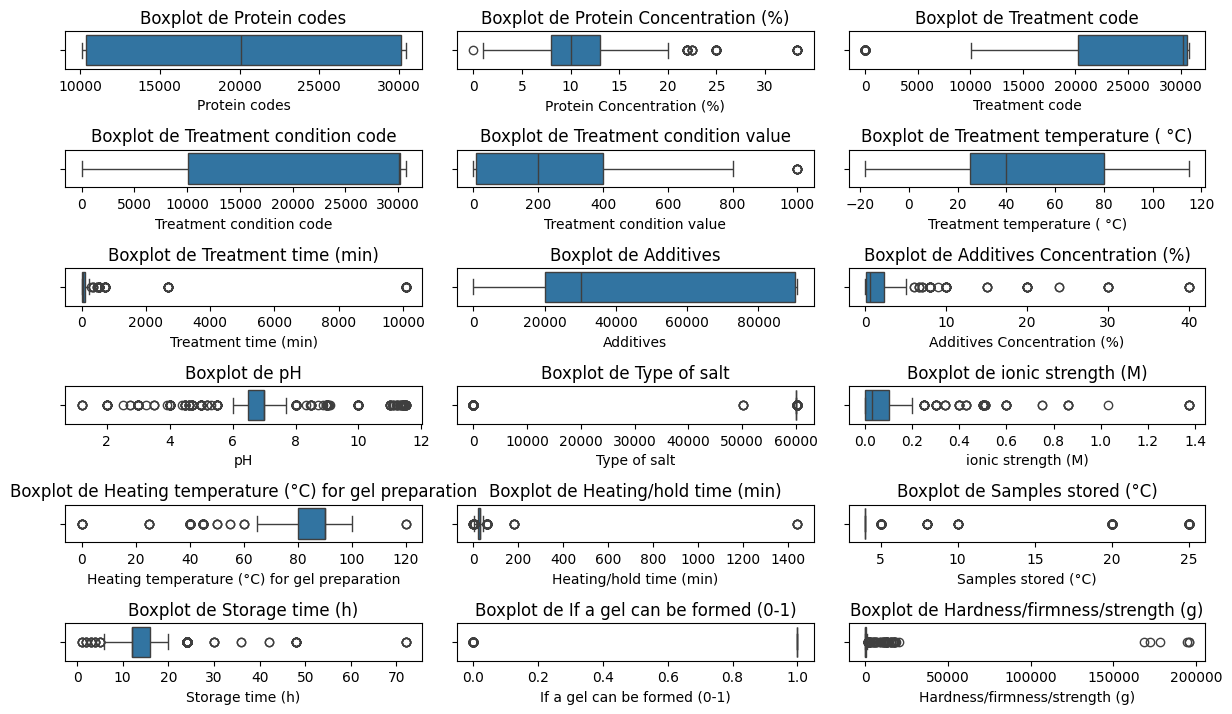

In [223]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_boxplots(df):
    """
    Affiche des boxplots pour toutes les colonnes numériques du DataFrame.
    
    Args:
    - df : DataFrame contenant les données à analyser.
    """
    # Sélectionner uniquement les colonnes numériques
    numeric_cols = df.select_dtypes(include=['number']).columns
    
    # Initialiser la figure
    plt.figure(figsize=(12, 8))
    
    # Créer un boxplot pour chaque colonne numérique
    for i, col in enumerate(numeric_cols):
        plt.subplot(len(numeric_cols)//3 + 1, 3, i + 1)
        sns.boxplot(x=df[col])
        plt.title(f'Boxplot de {col}')
    
    plt.tight_layout()  # Ajuster l'espacement entre les subplots
    plt.show()

# Exemple d'utilisation :
plot_boxplots(df)


In [224]:
import numpy as np

def replace_outliers_with_mean(df):
    """
    Remplace les outliers dans chaque colonne numérique par la moyenne de cette colonne.
    Un outlier est défini comme une valeur en dehors de [Q1 - 1.5 * IQR, Q3 + 1.5 * IQR].
    
    Args:
    - df : DataFrame contenant les données à analyser.
    
    Returns:
    - DataFrame avec les outliers remplacés par la moyenne.
    """
    # Sélectionner uniquement les colonnes numériques
    numeric_cols = df.select_dtypes(include=['number']).columns
    
    for col in numeric_cols:
        # Calculer les quartiles Q1 et Q3, ainsi que l'IQR (écart interquartile)
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        # Définir les limites pour les outliers
        lower_limit = Q1 - 1.5 * IQR
        upper_limit = Q3 + 1.5 * IQR
        
        # Remplacer les outliers par la moyenne de la colonne
        mean_value = df[col].mean()
        df[col] = df[col].apply(lambda x: mean_value if x < lower_limit or x > upper_limit else x)
        
    return df

# Exemple d'utilisation :
df = replace_outliers_with_mean(df)


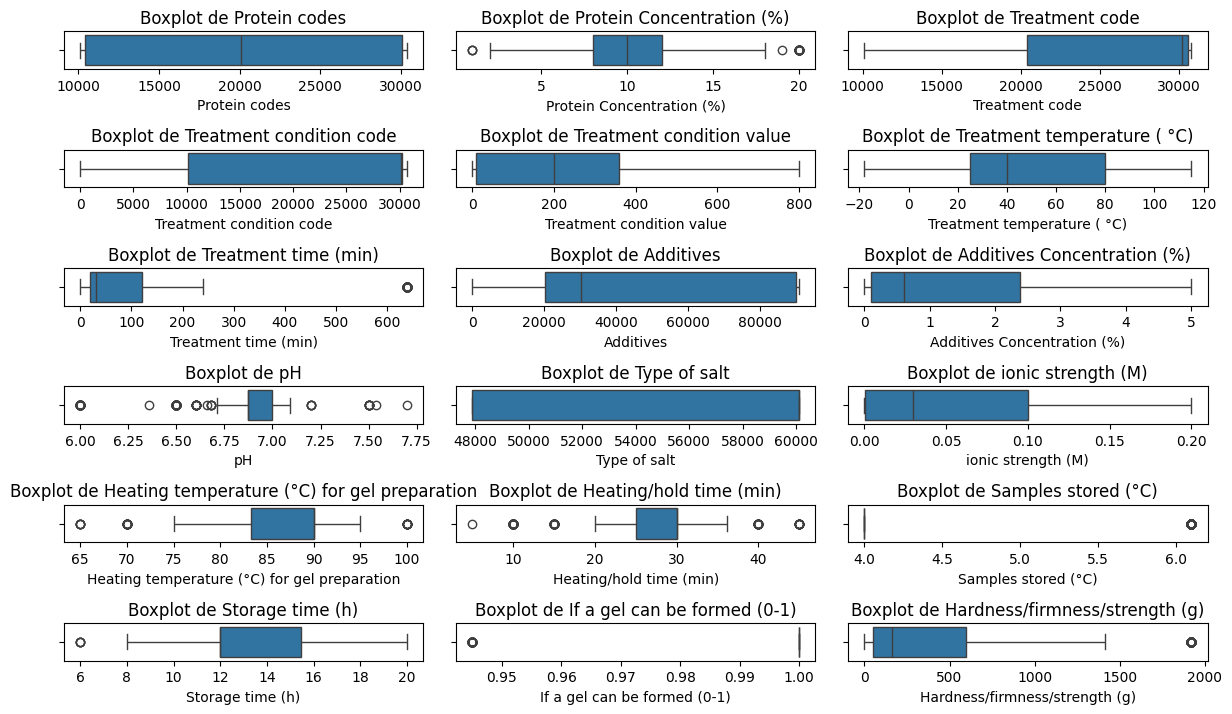

In [225]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_boxplots(df):
    """
    Affiche des boxplots pour toutes les colonnes numériques du DataFrame.
    
    Args:
    - df : DataFrame contenant les données à analyser.
    """
    # Sélectionner uniquement les colonnes numériques
    numeric_cols = df.select_dtypes(include=['number']).columns
    
    # Initialiser la figure
    plt.figure(figsize=(12, 8))
    
    # Créer un boxplot pour chaque colonne numérique
    for i, col in enumerate(numeric_cols):
        plt.subplot(len(numeric_cols)//3 + 1, 3, i + 1)
        sns.boxplot(x=df[col])
        plt.title(f'Boxplot de {col}')
    
    plt.tight_layout()  # Ajuster l'espacement entre les subplots
    plt.show()

# Exemple d'utilisation :
plot_boxplots(df)


In [226]:
df.isna().sum()

Protein codes                                     0
Protein Concentration (%)                         0
Treatment code                                  393
Treatment condition code                        786
Treatment condition value                       828
Treatment temperature ( °C)                     652
Treatment time (min)                            523
Additives                                       388
Additives Concentration (%)                     411
pH                                              207
Type of salt                                    514
ionic strength (M)                              514
Heating temperature (°C) for gel preparation    169
Heating/hold time (min)                         169
Samples stored (°C)                             105
Storage time (h)                                229
If a gel can be formed (0-1)                      0
Hardness/firmness/strength (g)                    0
dtype: int64

## Imputation with KNN

C:\Users\harri\AppData\Local\Temp\ipykernel_17364\2742268478.py:44: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  'Valeur': pd.concat([real_values, imputed_values], ignore_index=True),
C:\Users\harri\AppData\Local\Temp\ipykernel_17364\2742268478.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Type', y='Valeur', data=data, palette="Set2", ax=ax)
C:\Users\harri\AppData\Local\Temp\ipykernel_17364\2742268478.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Type',

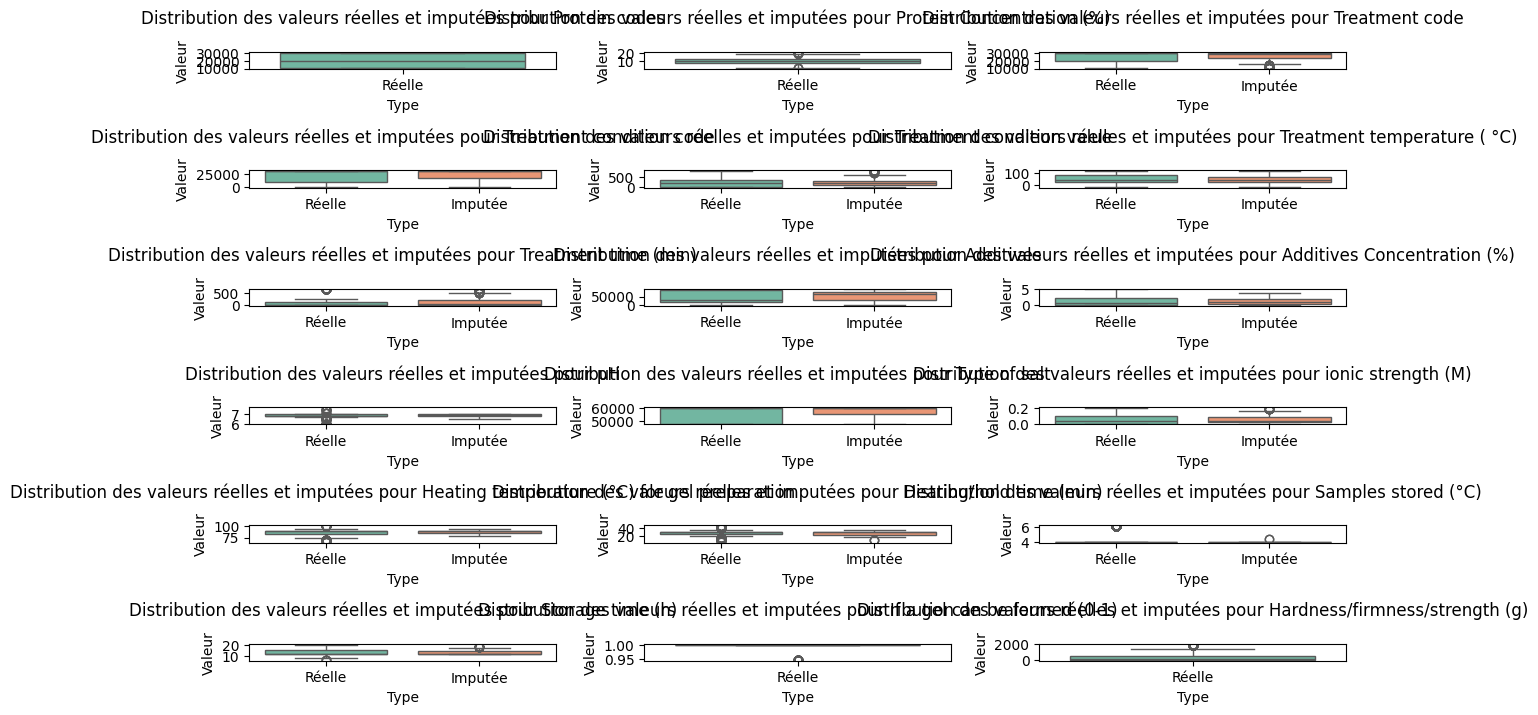

In [227]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import seaborn as sns

def knn_imputation_and_evaluation(df):
    """
    Effectue l'imputation KNN sur les colonnes numériques du DataFrame, puis compare
    les distributions des valeurs réelles et des valeurs imputées.
    
    Args:
    - df : DataFrame contenant les données à traiter.
    
    Retourne:
    - df_imputed : DataFrame avec les valeurs imputées.
    """
    # Sélectionner les colonnes numériques
    numeric_cols = df.select_dtypes(include=['number']).columns
    
    # Créer un masque pour les valeurs manquantes
    nan_mask = df[numeric_cols].isna()
    
    # Appliquer l'imputation KNN
    imputer = KNNImputer(n_neighbors=5)
    df_imputed = df.copy()
    
    # Appliquer l'imputation sur les colonnes numériques uniquement
    df_imputed[numeric_cols] = imputer.fit_transform(df[numeric_cols])
    
    # Comparer les distributions des valeurs réelles et des valeurs imputées
    # Visualisation avec des boxplots pour chaque colonne
    fig = plt.figure(figsize=(12, 8))
    
    for i, col in enumerate(numeric_cols):
        ax = fig.add_subplot(len(numeric_cols)//3 + 1, 3, i + 1)
        
        # Réinitialiser les index pour éviter les duplications après concaténation
        real_values = df[col].dropna().reset_index(drop=True)
        imputed_values = df_imputed.loc[nan_mask[col], col].reset_index(drop=True)
        
        # Combiner les valeurs réelles et imputées pour chaque colonne
        data = pd.DataFrame({
            'Valeur': pd.concat([real_values, imputed_values], ignore_index=True),
            'Type': ['Réelle'] * len(real_values) + ['Imputée'] * len(imputed_values)
        })
        
        # Plot des valeurs réelles et imputées avec un "hue" pour différencier
        sns.boxplot(x='Type', y='Valeur', data=data, palette="Set2", ax=ax)
        
        ax.set_title(f'Distribution des valeurs réelles et imputées pour {col}', fontsize=12, pad=20)
    
    # Ajuster les marges autour de l'ensemble de la figure pour les titres
    plt.subplots_adjust(hspace=0.6, top=0.9)  # Espacement entre les sous-figures et ajustement de la marge en haut
    plt.tight_layout()
    plt.show()
    
    return df_imputed

# Exemple d'utilisation :
df_imputed = knn_imputation_and_evaluation(df)


In [228]:
df_imputed.isna().sum()

Protein codes                                   0
Protein Concentration (%)                       0
Treatment code                                  0
Treatment condition code                        0
Treatment condition value                       0
Treatment temperature ( °C)                     0
Treatment time (min)                            0
Additives                                       0
Additives Concentration (%)                     0
pH                                              0
Type of salt                                    0
ionic strength (M)                              0
Heating temperature (°C) for gel preparation    0
Heating/hold time (min)                         0
Samples stored (°C)                             0
Storage time (h)                                0
If a gel can be formed (0-1)                    0
Hardness/firmness/strength (g)                  0
dtype: int64

## Univariate analysis on (Hardness/firmness/strength)

In [231]:
df_imputed["Hardness/firmness/strength (g)"].unique()

array([1.31910000e+02, 1.55910000e+02, 1.51140000e+02, 1.44840000e+02,
       9.57100000e+01, 1.07430000e+02, 1.09450000e+02, 1.18660000e+02,
       2.94500000e+01, 4.63400000e+01, 5.83800000e+01, 9.76500000e+01,
       6.06480000e+02, 0.00000000e+00, 4.61780000e+02, 5.45950000e+02,
       6.22050000e+02, 1.91941943e+03, 1.20244000e+03, 1.25950000e+02,
       2.51820000e+02, 3.19560000e+02, 1.17266000e+03, 1.09108000e+03,
       1.35620000e+03, 7.76000000e+01, 9.54400000e+01, 1.42760000e+02,
       1.83550000e+02, 6.00600000e+01, 7.24000000e+01, 4.74160000e+02,
       6.81160000e+02, 7.60700000e+02, 1.11960000e+02, 4.26230000e+02,
       6.57710000e+02, 1.08088000e+03, 5.14900000e+01, 5.38400000e+02,
       8.54510000e+02, 1.01664000e+03, 1.37558000e+03, 1.69270000e+02,
       1.30929000e+03, 5.30200000e+01, 6.32200000e+01, 7.54600000e+01,
       7.95400000e+01, 8.05600000e+01, 9.78900000e+01, 1.25420000e+02,
       1.57030000e+02, 1.19300000e+02, 2.07000000e+02, 2.59000000e+02,
      

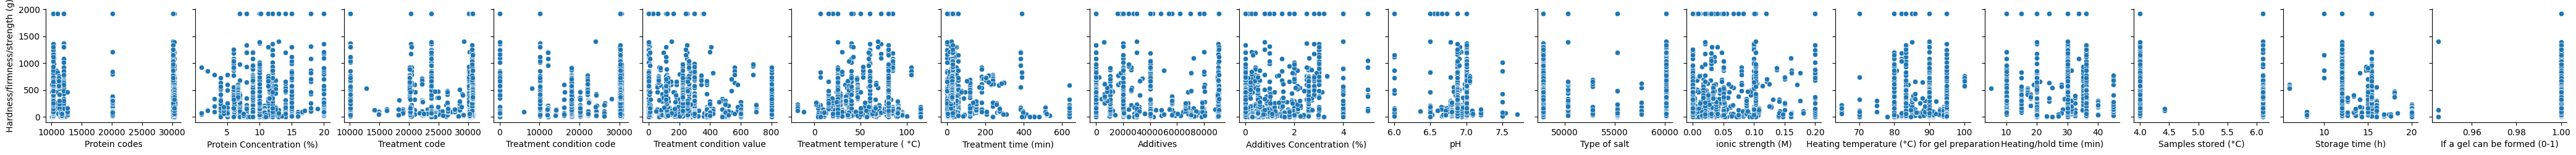

In [232]:
import seaborn as sns
import matplotlib.pyplot as plt

# Définir la variable pour l'axe Y
y_var = "Hardness/firmness/strength (g)"  # Remplace par le nom de ta colonne cible

# Sélectionner toutes les autres colonnes sauf y_var pour l'axe X
x_vars = [col for col in df.columns if col != y_var]

# Créer le pairplot en mode horizontal
sns.pairplot(df_imputed, x_vars=x_vars, y_vars=[y_var], diag_kind="kde", height=2.5)

# Afficher le graphique
plt.show()


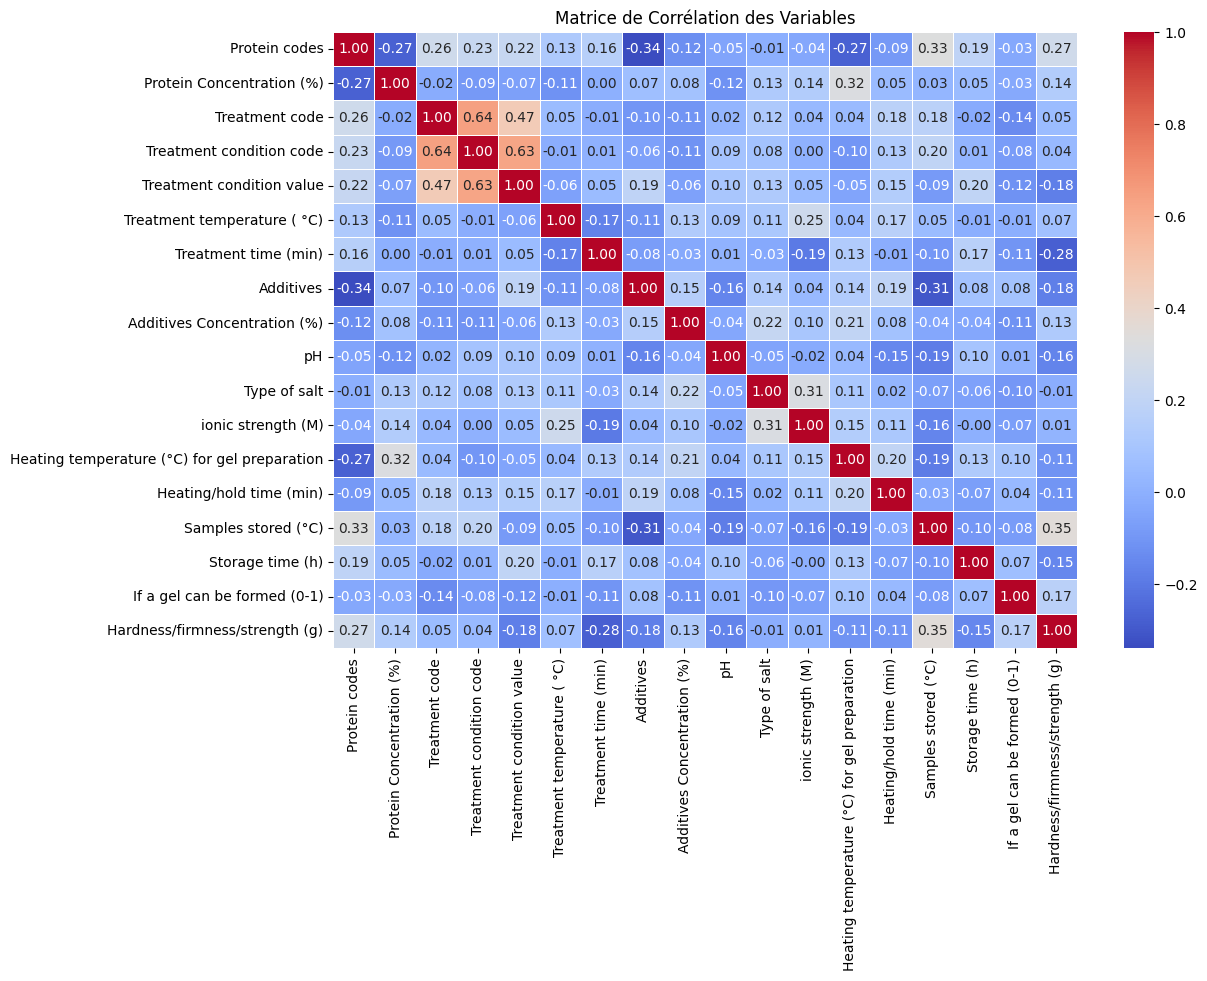

In [233]:
import seaborn as sns
import matplotlib.pyplot as plt

# Définition de la figure
plt.figure(figsize=(12, 8))

# Heatmap avec annotations et une palette de couleurs contrastée
sns.heatmap(df_imputed.select_dtypes(include="number").corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

# Ajout d'un titre
plt.title("Matrice de Corrélation des Variables")

# Affichage du graphique
plt.show()

## Correlation of Pearson

In [255]:
from scipy.stats import pearsonr

corr, p_value = pearsonr(df_imputed["Hardness/firmness/strength (g)"], df_imputed["Samples stored (°C)"])
print(f"Corrélation de Pearson : {corr:.2f}, p-value : {p_value:.5f}")

Corrélation de Pearson : 0.35, p-value : 0.00000


## Deleting outlier data

In [444]:
import numpy as np

# Calculer la médiane
median = df_clean_copy["Hardness/firmness/strength (g)"].mean()

# Calculer l'upper_bound en utilisant IQR (Interquartile Range)
Q1 = df_clean_copy["Hardness/firmness/strength (g)"].quantile(0.25)
Q3 = df_clean_copy["Hardness/firmness/strength (g)"].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR  # Le seuil pour les outliers

# Remplacer les valeurs au-dessus de l'upper_bound par la médiane
df_clean_copy["Hardness/firmness/strength (g)"] = np.where(df_clean_copy["Hardness/firmness/strength (g)"] > upper_bound, median, df_clean_copy["Hardness/firmness/strength (g)"])


<Axes: >

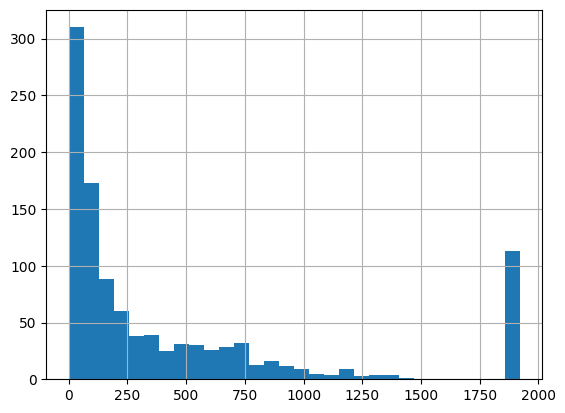

In [238]:
df_imputed["Hardness/firmness/strength (g)"].hist(bins=30)

In [325]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np

# X et y
X = df_imputed.drop('Hardness/firmness/strength (g)', axis=1)
y = df_imputed['Hardness/firmness/strength (g)']


## 2 - Train models

In [26]:
'''from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDRegressor, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor
from sklearn.svm import LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


# 2. Séparation des données en jeu d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


models = {
    "SGDRegressor": SGDRegressor(max_iter=1000, tol=1e-3, random_state=42),
    "ElasticNet": ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "AdaBoost": AdaBoostRegressor(n_estimators=100, random_state=42),
    "LinearSVR": LinearSVR(random_state=42),
    "KNeighbors": KNeighborsRegressor(n_neighbors=5),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    
}'''

'from sklearn.pipeline import Pipeline\nfrom sklearn.linear_model import SGDRegressor, ElasticNet\nfrom sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor\nfrom sklearn.svm import LinearSVR\nfrom sklearn.neighbors import KNeighborsRegressor\nfrom sklearn.linear_model import LinearRegression\nfrom sklearn.model_selection import train_test_split\n\n\n# 2. Séparation des données en jeu d\'entraînement et de test\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)\n\n\nmodels = {\n    "SGDRegressor": SGDRegressor(max_iter=1000, tol=1e-3, random_state=42),\n    "ElasticNet": ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42),\n    "GradientBoosting": GradientBoostingRegressor(n_estimators=100, random_state=42),\n    "AdaBoost": AdaBoostRegressor(n_estimators=100, random_state=42),\n    "LinearSVR": LinearSVR(random_state=42),\n    "KNeighbors": KNeighborsRegressor(n_neighbors=5),\n    "RandomForest": RandomFor

In [326]:
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import lightgbm as lgb

# 5. Séparation des données en ensembles d'entraînement et de test (80% Train et 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 8. Initialisation des modèles
models = {
    "SGDRegressor": SGDRegressor(max_iter=1000, tol=1e-3, random_state=42),
    "ElasticNet": ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "AdaBoost": AdaBoostRegressor(n_estimators=100, random_state=42),
    "LinearSVR": LinearSVR(random_state=42),
    "KNeighbors": KNeighborsRegressor(n_neighbors=5),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "CatBoost": CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, random_state=42, verbose=0),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42),
    "LightGBM": lgb.LGBMRegressor(n_estimators=100, random_state=42)
}

In [327]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# 9. Entraînement et évaluation des modèles
results = []

# Boucle sur les modèles
for name, model in models.items():
    # Création d'un pipeline avec le modèle
    pipeline = Pipeline([("model", model)])
    
    # Entraînement
    pipeline.fit(X_train, y_train)
    
    # Prédictions
    y_pred = pipeline.predict(X_test)
    
    # Calcul des métriques
    metrics = {
        "R²": r2_score(y_test, y_pred) * 100,  # Conversion en pourcentage
        "MAE": mean_absolute_error(y_test, y_pred),
        "MSE": mean_squared_error(y_test, y_pred)
    }
    
    # Stockage des résultats dans une liste
    results.append({"Modèle": name, **metrics})

# 10. Affichage des résultats sous forme de DataFrame
df_results = pd.DataFrame(results).sort_values(by="R²", ascending=False)

# Arrondir R² à 2 décimales et forcer l'affichage sans notation scientifique
df_results["R²"] = df_results["R²"].apply(lambda x: f"{x:.2f}")

# Affichage des résultats
df_results



c:\Users\harri\anaconda3\envs\notebook\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000363 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 732
[LightGBM] [Info] Number of data points in the train set: 858, number of used features: 17
[LightGBM] [Info] Start training from score 435.554899
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


,Modèle,R²,MAE,MSE
8,XGBoost,91.82,7.866903e+01,2.781411e+04
7,CatBoost,91.79,8.769363e+01,2.791720e+04
6,RandomForest,91.07,9.735328e+01,3.036396e+04
2,GradientBoosting,86.67,1.363727e+02,4.532605e+04
9,LightGBM,79.06,1.345717e+02,7.120527e+04
3,AdaBoost,68.54,2.573252e+02,1.069972e+05
5,KNeighbors,68.21,1.585822e+02,1.081121e+05
1,ElasticNet,31.72,3.573740e+02,2.322170e+05
4,LinearSVR,-42.19,5.876654e+02,4.835837e+05
0,SGDRegressor,-2917768096121403685887077123096576.00,2.821349e+18,9.922888e+36


## First training of Random Forest with outlier data

In [266]:
# Vérifier les colonnes de X_train et X_test
print(f"Colonnes de X_train : {X_train.shape}")
print(f"Colonnes de X_test : {X_test.shape}")

Colonnes de X_train : (858, 17)
Colonnes de X_test : (215, 19)


In [348]:
from sklearn.impute import SimpleImputer
from catboost import CatBoostRegressor

# Créer et entraîner le modèle CatBoost avec les données transformées
XG_boost_model = XGBRegressor(n_estimators=100, random_state=42) # Désactiver les logs pour un affichage propre
XG_boost_model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

R² Score: 0.9182


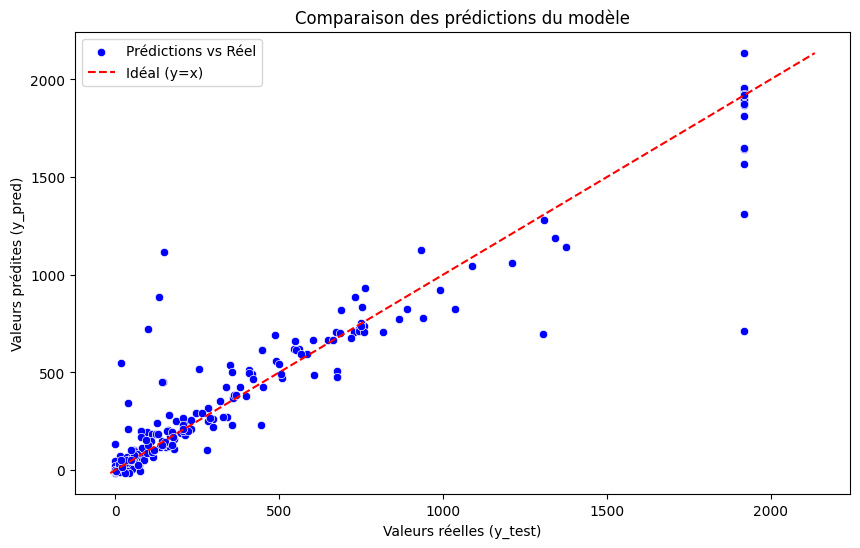

In [349]:
from sklearn.metrics import r2_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Prédictions du modèle sur les données de test
y_pred = XG_boost_model.predict(X_test)

# Calcul du score R² sur les données de test
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2:.4f}")

# Tracer le graphique de dispersion entre les valeurs réelles et les valeurs prédites
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=y_test,  # Valeurs réelles
    y=y_pred,  # Valeurs prédites
    color='blue',  
    label='Prédictions vs Réel'
)

# Ajouter une ligne de régression idéale (y = x) pour comparaison
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='dashed', label="Idéal (y=x)")

# Labels et titre
plt.xlabel("Valeurs réelles (y_test)")
plt.ylabel("Valeurs prédites (y_pred)")
plt.title("Comparaison des prédictions du modèle")
plt.legend()
plt.show()


## CROSS VALIDATION ON 5-KFOLD

In [350]:
from sklearn.model_selection import cross_val_score, KFold
import numpy as np

# Définir la validation croisée (5 folds)
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Appliquer la validation croisée avec R² comme métrique
scores = cross_val_score(XG_boost_model, X_train, y_train, cv=cv, scoring='r2')

# Afficher les résultats
print(f"Scores de chaque fold: {scores}")
print(f"R² moyen: {np.mean(scores):.4f}")
print(f"Écart-type des scores: {np.std(scores):.4f}")


Scores de chaque fold: [0.90155194 0.87300036 0.91497773 0.88802674 0.84191221]
R² moyen: 0.8839
Écart-type des scores: 0.0252


In [354]:
# 2. Créer une copie de X_test pour éviter toute modification non voulue
X_test_copy = X_test.copy()

# 3. Ajouter les colonnes de labels réels et prédits
X_test_copy['True label'] = y_test
X_test_copy['Predict Label'] = y_pred

# 4. Définir la tolérance de 30% pour les prédictions correctes
tol = 0.6

# 5. Filtrer les prédictions correctes en fonction de la tolérance
correct_predictions = X_test_copy[np.abs(X_test_copy['True label'] - X_test_copy['Predict Label']) < tol]

# 6. Afficher un échantillon de prédictions correctes (maximum de 11 échantillons)
sample_size = min(11, len(correct_predictions))
correct_predictions.sample(sample_size)


,Protein codes,Protein Concentration (%),Treatment code,Treatment condition code,Treatment condition value,Treatment temperature ( °C),Treatment time (min),Additives,Additives Concentration (%),pH,Type of salt,ionic strength (M),Heating temperature (°C) for gel preparation,Heating/hold time (min),Samples stored (°C),Storage time (h),If a gel can be formed (0-1),True label,Predict Label
904,30303.0,10.0,24383.4,12060.6,9.04,20.8,120.000000,40205.2,0.28,6.872206,60101.0,0.05200,80.0,20.0,4.0,12.0,1.000000,5.00,5.117233
891,30303.0,9.0,24383.4,12060.6,9.04,20.8,120.000000,40205.2,0.28,7.000000,60101.0,0.05200,80.0,20.0,4.0,12.0,1.000000,10.17,9.612454
897,30104.0,8.5,30305.0,30602.0,800.00,57.0,431.251636,42245.0,3.20,7.000000,60102.6,0.09267,80.0,20.0,4.0,12.0,0.945014,0.00,0.371806
158,30105.0,6.0,30705.0,30602.0,800.00,25.0,120.000000,90409.0,2.00,7.000000,60103.0,0.00600,90.0,30.0,4.0,12.0,1.000000,54.65,54.226616


## Check the homoscedasticity of the residuals and the distribution of the residuals

✔ If the residuals (errors between prediction and true value) are randomly distributed around zero (without any obvious structure), this means that the homoscedasticity assumption is met.

❌ If a particular shape appears (e.g. open or closed cone), this indicates heteroscedasticity, which can distort predictions and require data transformation.

✔ If the residuals have a bell-shaped (Gaussian) distribution, then the normality hypothesis is respected.

❌ If the residuals are asymmetric or have extreme values ​​(thick tails), this may indicate the presence of outliers or the need for a data transformation (e.g. logarithmic).

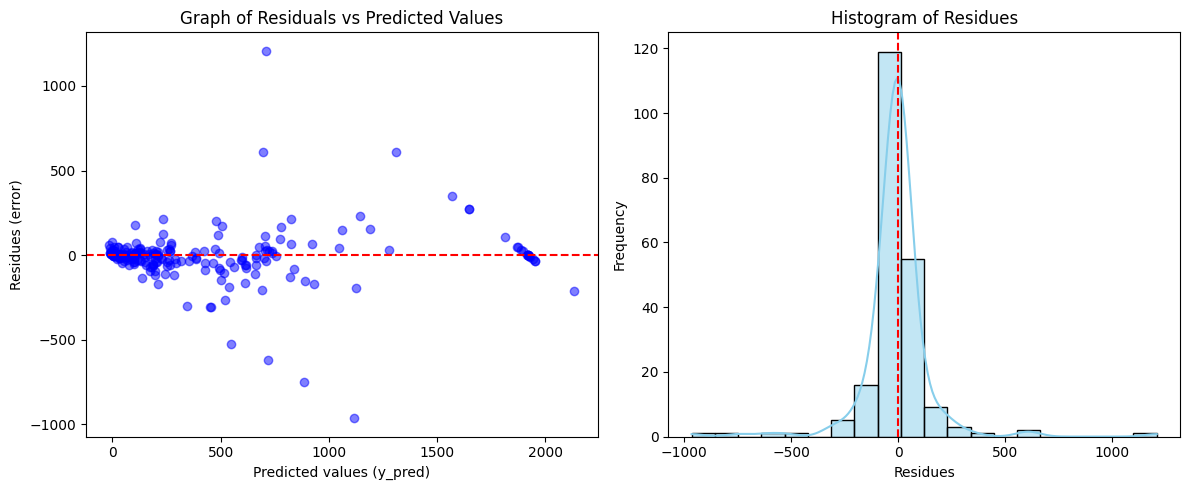

Skewness : 0.6396
Kurtosis : 20.6629


In [352]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


# Calculation of residuals
residuals = y_test - y_pred

# Creating a single figure with 2 sub-graphs
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

#1st Graph: Plot of residuals vs predicted values
axes[0].scatter(y_pred, residuals, color="blue", alpha=0.5)
axes[0].axhline(y=0, color="red", linestyle="dashed")  # Ligne horizontale à 0
axes[0].set_xlabel("Predicted values ​​(y_pred)")
axes[0].set_ylabel("Residues (error)")
axes[0].set_title("Graph of Residuals vs Predicted Values")

#2nd Graph: Histogram of residuals
sns.histplot(residuals, bins=20, kde=True, color="skyblue", edgecolor="black", ax=axes[1])
axes[1].axvline(x=0, color='red', linestyle='dashed')  # Ligne centrale
axes[1].set_title("Histogram of Residues")
axes[1].set_xlabel("Residues")
axes[1].set_ylabel("Frequency")

# Display
plt.tight_layout()
plt.show()

print(f"Skewness : {stats.skew(residuals):.4f}")
print(f"Kurtosis : {stats.kurtosis(residuals):.4f}")


In [353]:
from statsmodels.stats.diagnostic import het_breuschpagan
import statsmodels.api as sm

# Ajouter une constante aux variables explicatives
X = sm.add_constant(X_test)

# Exécuter le test de Breusch-Pagan
test = het_breuschpagan(residuals, X)
p_value = test[1]

# Affichage des résultats avec interprétation
print(f"Breusch-Pagan p-value: {p_value:.4f}")

if p_value < 0.05:
    print("🔴 Hétéroscédasticité détectée : La variance des résidus n'est pas constante.")
    print("📌 Il peut être nécessaire d'appliquer une transformation des données ou d'utiliser une régression robuste.")
else:
    print("🟢 Homoscédasticité confirmée : La variance des résidus est constante.")
    print("✅ Aucune correction nécessaire pour l’hétéroscédasticité.")


Breusch-Pagan p-value: 0.7106
🟢 Homoscédasticité confirmée : La variance des résidus est constante.
✅ Aucune correction nécessaire pour l’hétéroscédasticité.


In [340]:
from scipy.stats import shapiro

stat, p_value = shapiro(residuals)
print(f"Shapiro-Wilk test p-value: {p_value:.4f}")

if p_value > 0.05:
    print("The residuals follow a normal distribution (normality hypothesis accepted).")
else:
    print("The residuals do not follow a normal distribution (normality hypothesis rejected).")


Shapiro-Wilk test p-value: 0.0000
The residuals do not follow a normal distribution (normality hypothesis rejected).


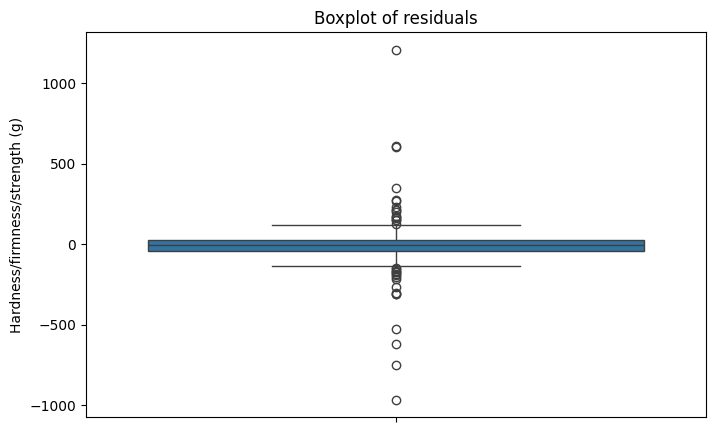

In [341]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.boxplot(y=residuals)
plt.title("Boxplot of residuals")
plt.show()


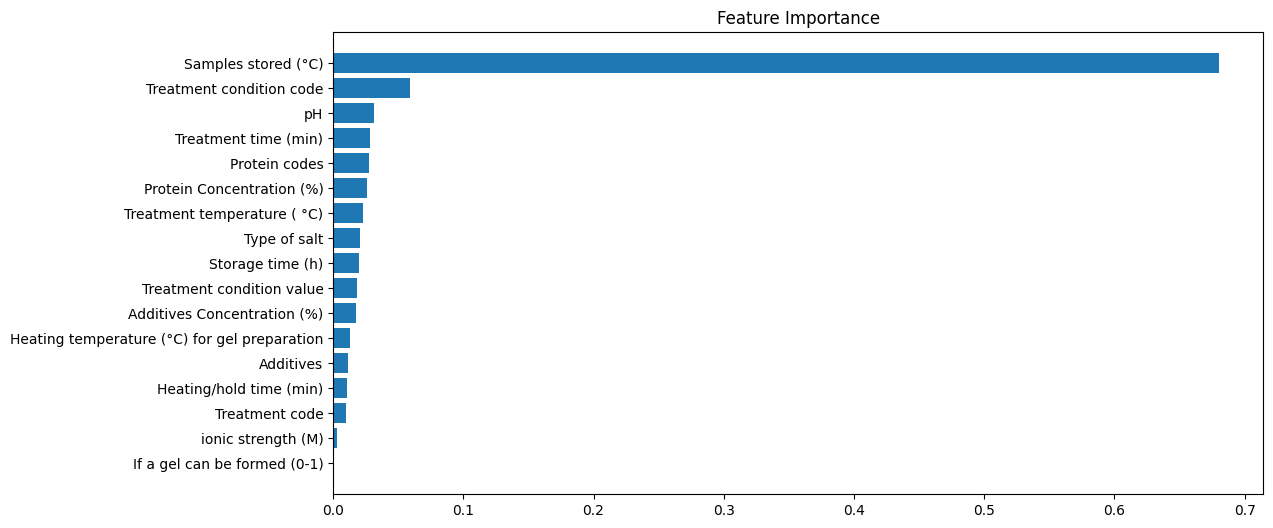

In [342]:
from matplotlib import pyplot as plt

feature_importance = XG_boost_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')
plt.show()

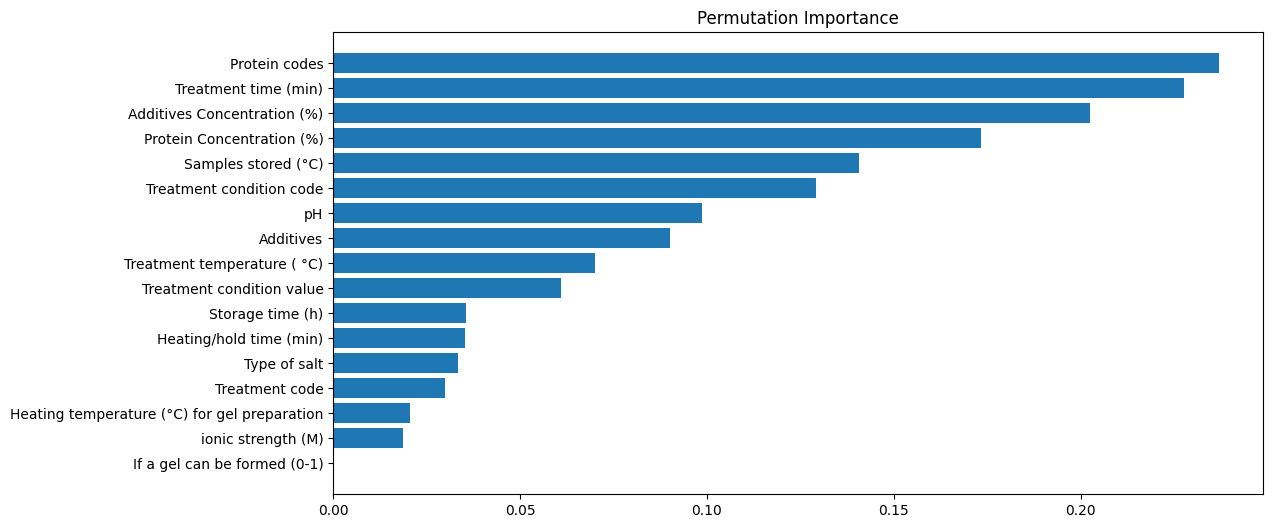

In [343]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(XG_boost_model, X_test, y_test, n_repeats=10, random_state=1066)
sorted_idx = perm_importance.importances_mean.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Permutation Importance')
plt.show()

### Explanation using SHAP values

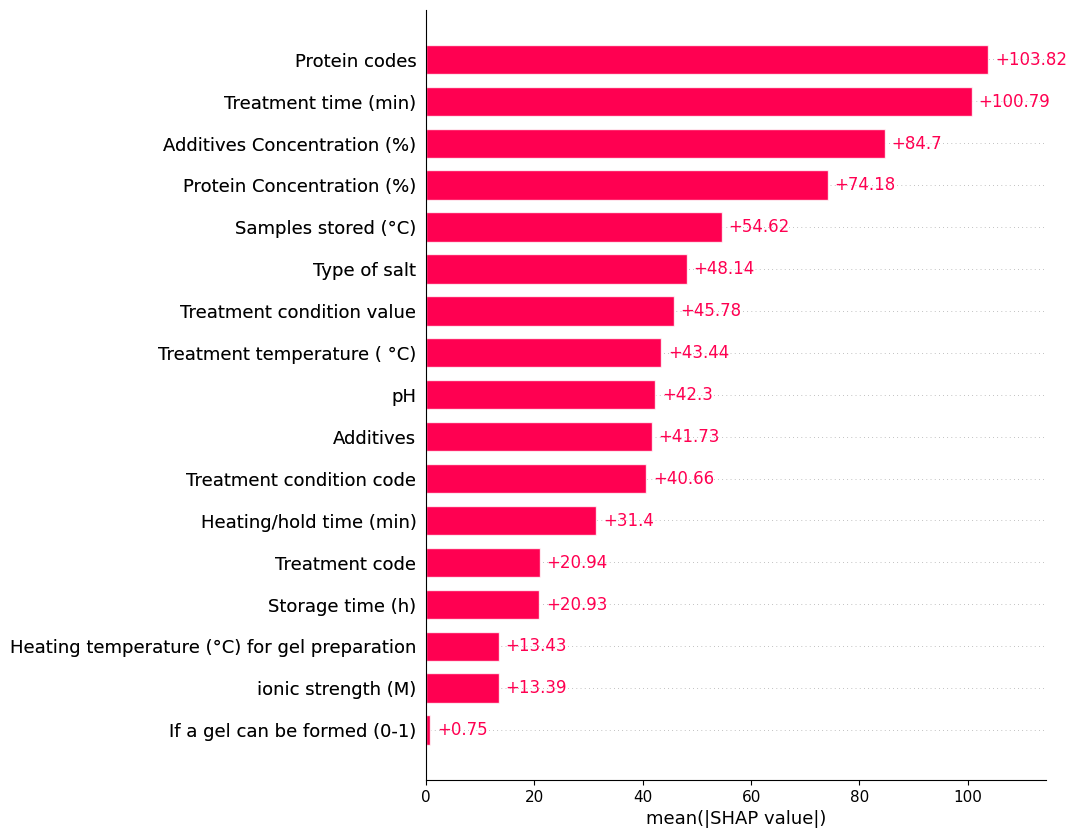

In [344]:
import shap
explainer = shap.TreeExplainer(XG_boost_model)
shap_values = explainer(X_test)
shap.plots.bar(shap_values, max_display=X_test.shape[0])

### Explanation for Technical Audience (Data Scientists):
This SHAP summary plot shows the average magnitude of SHAP values for features used in a **CatBoostRegressor model**. The SHAP value for each feature represents its contribution to the model's predictions. The features are ranked in descending order of importance based on their mean absolute SHAP values. 

- **"Ionic strength (M)"** has the highest importance, indicating it significantly impacts the model's predictions.
- Features like **"Samples stored (°C)"** and **"Type of salt"** also play crucial roles but are less influential compared to "Ionic strength."
- Features such as **"Additives"** and **"Protein codes"** have much smaller SHAP values, implying they contribute less to the prediction.

The results can guide feature engineering and domain understanding by highlighting which variables are driving the predictions.

---

### Explanation for Non-Technical Stakeholders:
This plot helps us understand which factors are most important for the predictions made by the model. Each bar represents how much a specific factor (like **"Ionic strength"** or **"Samples stored temperature"**) influences the model's outcomes on average.

- The top factor, **"Ionic strength"**, has the biggest influence, meaning it strongly affects how the predictions change.
- Factors like the **"storage temperature"** and the **"type of salt"** are also quite important, but less so than ionic strength.
- Factors lower down, like **"Additives"**, have very little impact on the model's predictions.

This information can help focus on the most critical factors for decision-making or further experimentation.

In [28]:
shap.initjs()
shap.plots.force(shap_values[0, ...])

In [30]:
shap.initjs()
shap.plots.force(shap_values[11, ...])

The above explanation shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue.

### Using DiCE library for counterfactual explanations

In [40]:
import dice_ml
from dice_ml import Dice

d_gel = dice_ml.Data(dataframe=df_clean,
                      continuous_features=list(numerical_cols),
                      outcome_name='Hardness/firmness/strength (g)')

# We provide the type of model as a parameter (model_type)
catboost_with_preprocessing = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', CatBoostRegressor(random_state=RANDOM_STATE, verbose=False))])
catboost_with_preprocessing.fit(X_train, y_train)
m_gel = dice_ml.Model(model=catboost_with_preprocessing, backend="sklearn", model_type='regressor')
exp_genetic_gel = Dice(d_gel, m_gel, method="genetic")

In [45]:
# Multiple queries can be given as input at once
# query_instances_gel = X_test[20:22]
# genetic_gel = exp_genetic_gel.generate_counterfactuals(
#     query_instances_gel,
#     total_CFs=2,
#     desired_range=[100, 500])
# genetic_gel.visualize_as_dataframe(show_only_changes=True)

In [ ]:
import joblib
joblib.dump(XG_boost_model, 'modelBoosting.joblib')

In [ ]:
# load model and predict
loaded_model = joblib.load('modelBoosting.joblib')
loaded_model.predict(X_test)